In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT
from ATARI.syndat.control import Syndat_Control


In [2]:
%matplotlib widget

## AutoFit User Example

This notebook gives an examle how the ATARI.AutoFit module can be used to automatically fit data with no need for a prior.

In [3]:
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')
        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i]['true'], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

## First, generate data with Syndat to play with

In [4]:
### Reaction Model
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,250],
                        ac = 8.127,
                        M = 180.94803,
                        I = 3,
                        l_max = 2
)

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

### Experimental Models
cap1mm_exp_gen = Experimental_Model(title = "cap1",
                                reaction ="capture", 
                                energy_range = [200, 250],
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )

trans1mm_exp_gen = Experimental_Model(title = "trans1",
                               reaction = "transmission", 
                               energy_range = [200,250],
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),
                               channel_widths={
                                    "maxE": [216.16, 613.02], 
                                    "chw": [204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                }
                               )

sammy_rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })

template_creator.make_input_template('template_T.inp', Ta_pair, trans1mm_exp_gen, sammy_rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, cap1mm_exp_gen, sammy_rto)

cap1mm_exp_gen.template = os.path.realpath('template_Y.inp')
trans1mm_exp_gen.template = os.path.realpath('template_T.inp')

### Measurement Models
cap1mm_meas_gen = Capture_Yield_RPI()
cap1mm_meas_red = Capture_Yield_RPI()

trans1mm_meas_gen = Transmission_RPI()
trans1mm_meas_red = Transmission_RPI()


### Syndat Models
options_cap1mm = syndatOPT(calculate_covariance=False)

syndat_cap1mm = Syndat_Model(cap1mm_exp_gen,
                            cap1mm_meas_gen,
                            cap1mm_meas_red,
                            options = options_cap1mm,
                            title='cap1mm')

options_trans1mm = syndatOPT(calculate_covariance = True)
syndat_trans1mm = Syndat_Model(trans1mm_exp_gen,
                            trans1mm_meas_gen,
                            trans1mm_meas_red,
                            options = options_trans1mm,
                            title='trans1mm')

In [5]:
### Control module for sampling from multiple syndat models

options_control = syndatOPT()
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= [syndat_trans1mm, syndat_cap1mm],
                        model_correlations=None,
                        options=options_control
                        )

syndat.sample(sammy_rto, num_samples=2)

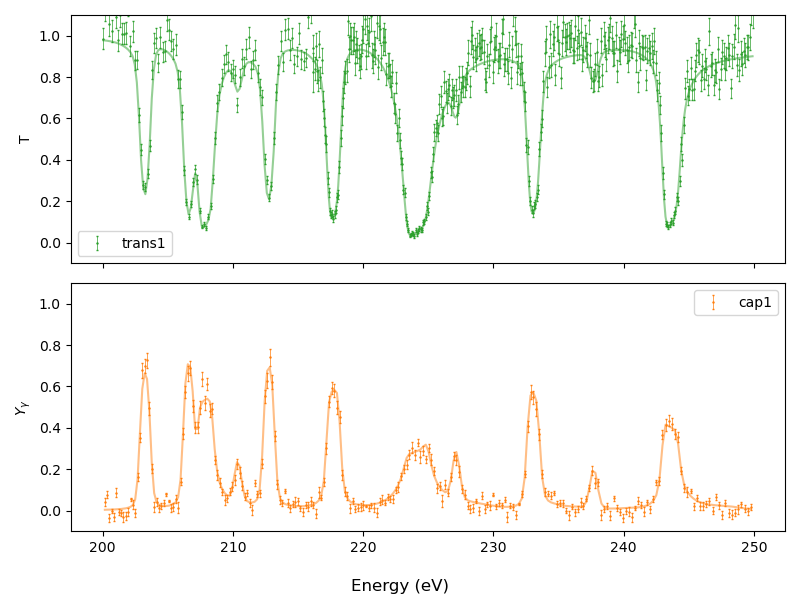

In [6]:
### unpack sample and plot

sample1 = syndat.get_sample(1)

datasets = [sample1['cap1mm'].pw_reduced, sample1['trans1mm'].pw_reduced]#, transdat3, transdat6]
experiments= [cap1mm_exp_gen, trans1mm_exp_gen]#, exptrans3, exptrans6]
covariance_data = [sample1['cap1mm'].covariance_data, sample1['trans1mm'].covariance_data]

fig = plot(datasets, experiments, fits=[], priors=[], true=datasets)
fig.tight_layout()

In [19]:
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = InitialFBOPT(Gn_threshold=1e-2,
                       iterations=0)
autofit_initial = InitialFB(options)

In [20]:
outs = autofit_initial.fit(Ta_pair,
                               [200,250],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 124 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.5  : [68.9962, 613.799, 682.7952]
1    0.75 : [34.8641, 98.0023, 132.8664]
Repeat step 2, 	fudge: ['cap1', 'trans1', 'sum']
		0.15 : [29.4044, 131.966, 161.3704]
		0.03 : [33.0712, 60.045, 93.1162]
2    0.03 : [33.0712, 60.045, 93.1162]
3    0.045: [30.9436, 40.6352, 71.5788]
4    0.068: [27.8741, 25.1787, 53.0528]
5    0.101: [24.1662, 15.7192, 39.8854]
6    0.152: [21.8582, 12.1475, 34.0057]
7    0.228: [19.8429, 10.8256, 30.6685]
8    0.342: [17.7765, 9.7811, 27.5576]
9    0.513: [16.8656, 9.4457, 26.3113]
10    0.769: [15.8668, 9.2668, 25.1336]
11    1.153: [15.3318, 9.2372, 24.569]
12    1.73 : [15.0417, 9.0955, 24.1372]
13    2.595: [14.788, 9.0076, 23.7956]
14    3.892: [14.5898, 8.9398, 23.5296]
15    5.839: [14.4365, 8.8917, 23.3282]
16    8.758: [14.3596, 8.8637, 23.2233]
17    10.0 : [14.3477, 8.8737, 23.2214]
Chi2 improvement below threshold


In [21]:
final_fb_output = outs[-1]
len(final_fb_output.par_post)


45

In [22]:
final_fb_output.pw_post[0]

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,200.176298,0.041750,0.019209,0.042133,NaN,NaN,NaN,NaN,NaN
1,200.354155,0.075564,0.017077,0.025566,NaN,NaN,NaN,NaN,NaN
2,200.532249,-0.038012,0.019547,0.011446,NaN,NaN,NaN,NaN,NaN
3,200.710580,-0.002918,0.010063,0.005928,NaN,NaN,NaN,NaN,NaN
4,200.889150,-0.031221,0.018523,0.004938,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
232,248.785641,0.006381,0.021515,0.023905,NaN,NaN,NaN,NaN,NaN
233,249.032087,0.029517,0.010724,0.026004,NaN,NaN,NaN,NaN,NaN
234,249.278900,0.009709,0.018745,0.021333,NaN,NaN,NaN,NaN,NaN
235,249.526080,-0.002740,0.016514,0.014143,NaN,NaN,NaN,NaN,NaN


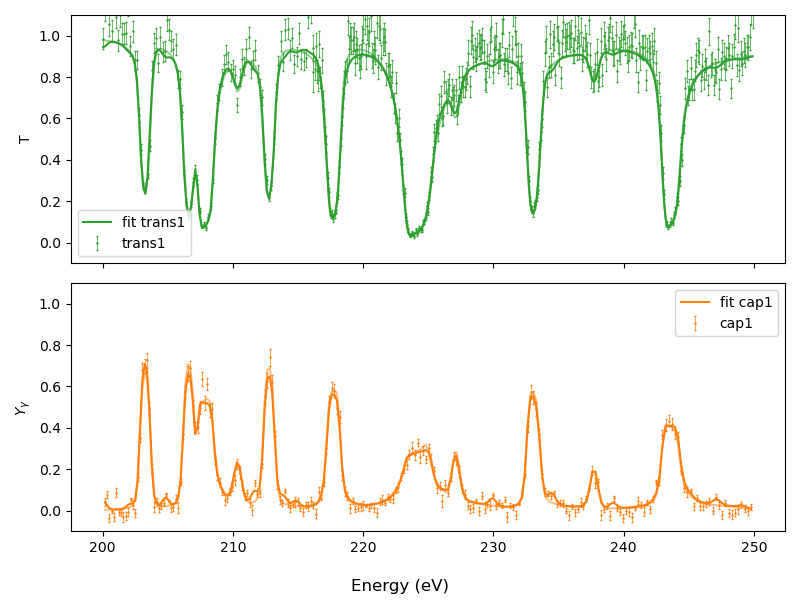

In [29]:
fig = plot(datasets, experiments, fits=final_fb_output.pw_post, priors=[], true=datasets)
ax = fig.get_axes()
# ax[1].plot(final_fb_output.pw_post[0].E,np.flipud(final_fb_output.pw_post[0].theo_xs), 'k')

# fig.tight_layout()

In [24]:
import importlib
from ATARI.AutoFit import chi2_eliminator_v2

importlib.reload(chi2_eliminator_v2)


start_ladder = final_fb_output.par_post
assert isinstance(start_ladder, pd.DataFrame)

# side resonances - keep empty
side_resonances_df = pd.DataFrame()

# defining rto & inputs

elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 0,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.1
    )

# defining the elim_opts
elim_opts = chi2_eliminator_v2.elim_OPTs(chi2_allowed = 28,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 5,
                                      deep_fit_step_thr = 0.01,
                                      start_fudge_for_deep_stage = 0.1
                                      )

In [25]:
elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
                                            sammyINPyw = elim_sammyINPyw , 
                                            options = elim_opts
                            )

In [26]:
hist = elimi.eliminate(ladder_df=final_fb_output.par_post)

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 28


Input ladder:
             E          Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0   199.983175   61.394957    0.048510    1.0     1.0      1.0   1.0
1   202.101703   51.402355    0.274240    1.0     1.0      1.0   1.0
2   203.261040   37.252017   11.968261    1.0     1.0      1.0   1.0
3   204.839256   26.980170    0.618709    1.0     1.0      1.0   1.0
4   206.609428   63.315443   34.651431    1.0     1.0      1.0   1.0
5   207.777417   37.399748   12.540582    1.0     1.0      1.0   1.0
6   212.782101   61.289803   35.149532    1.0     1.0      1.0   1.0
7   213.896343   31.418379    0.591266    1.0     1.0      1.0   1.0
8   214.767786   63.700836    0.011875    1.0     1.0      1.0   1.0
9   217.732860   73.154943   71.322852    1.0     1.0      1.0   1.0
10  224.960591    4.626142   12.096462    1.0     1.0      1.

In [38]:
print(f'Eliminated from {hist.ladder_IN.shape[0]} res -> {hist.ladder_OUT.shape[0]}')
minkey = min(hist.elimination_history.keys())
sammyOUT_elim = hist.elimination_history[minkey]['selected_ladder_chars']

Eliminated from 45 res -> 20


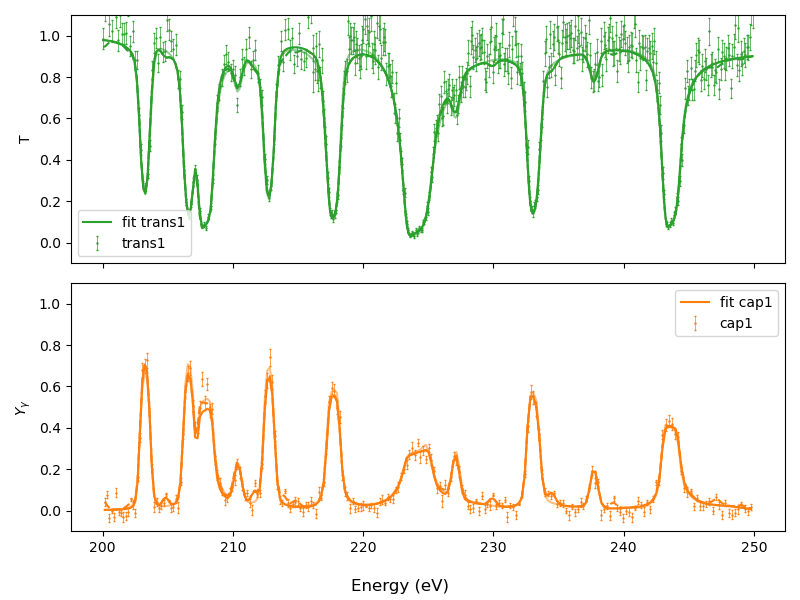

In [39]:

# outfit
fig = plot(datasets, experiments, fits=sammyOUT_elim.pw, priors=final_fb_output.pw_post, true=datasets)
fig.tight_layout()